# Sequential Attend, Infer, Repeat (SQAIR)
This notebook loads a pre-trained model checkpoints, evaluates it on the validation dataset and plots reconstructions with attention bounding-boxes.

##### General Imports

In [1]:
import itertools
import os
import numpy as np
import tensorflow as tf

import sys
sys.path.append('../')

from sqair.experiment_tools import (load, init_checkpoint, parse_flags, get_session, print_flags,
                                      print_num_params, print_variables_by_scope)
from sqair import tf_flags as flags
from sqair.eval_tools import bbox_colors, make_expr_logger, rect_stn
from sqair.modules import SpatialTransformer as ST

import matplotlib.pyplot as plt
% matplotlib inline

#### Model config
This notebook loads a pre-trained model checkpoint by default. To change which checkpoint is loaded, change the `checkpoint_iter` variable below. The only checkpoint that comes with the github repo is `1000000` or `int(1e6)`. 

You can run `scripts/download_models.sh` to download checkpoints saved after `int(i * 1e5) for i in [1, ..., 11]` training iterations.

Note that the model is trained with a curriculum of sequences of increasing length. After the model is resumed, you can query the starting sequence length by printing `F.seq_len` and the number of iterations it is trained with this sequence length by printing `F.stage_itr`. The maximum sequence length is 10 time-steps. If you load any checkpoint but the last one, the longest sequence the model has seen until this point might be smaller than 10.

In [2]:
F = flags.FLAGS
F.data_config = '../sqair/configs/seq_mnist_data.py'
F.model_config = '../sqair/configs/mlp_mnist_model.py'
F.batch_size = 32
F.debug = False

# Length of iamge sequences
sequence_length = 10

# The model will be evaluated on this many batches from the validation set. 
# Set this -1 to evaluate on the whole validation set.
num_eval_batches = 2  

checkpoint_iter = int(10e5)
checkpoint_dir = '../release_models/mnist_mlp/'

In [3]:
resume_checkpoint = '1/model.ckpt-{}'.format(checkpoint_iter)
resume_checkpoint = os.path.join(checkpoint_dir, resume_checkpoint)
logdir, flags, _ = init_checkpoint(checkpoint_dir, F.data_config, F.model_config, True)
F.seq_len = sequence_length

loading flags from ../sqair/configs/mlp_mnist_model.py
loading flags from ../sqair/configs/seq_mnist_data.py


#### Load the model

In [4]:
cwd = os.getcwd()
os.chdir('../sqair')

In [5]:
tf.reset_default_graph()
data_dict = load(F.data_config, F.batch_size)

# mean img
imgs = data_dict.train_data.imgs
mean_img = imgs.mean(tuple(range(len(imgs.shape) - 2)))
assert len(mean_img.shape) == 2

try:
    coords = data_dict.train_coord
except AttributeError:
    coords = None

model = load(F.model_config, img=data_dict.train_img, coords=coords, num=data_dict.train_num,
             mean_img=mean_img)

Loading 'seq_mnist_data' from ../sqair/configs/seq_mnist_data.pyc
Loading 'mlp_mnist_model' from ../sqair/configs/mlp_mnist_model.pyc
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
os.chdir(cwd)

In [7]:
print_flags()
print '\nTrainable Variables:'
print_variables_by_scope()
print_num_params()

Flags:
	batch_size: 32
	constant_prop_prior: 0.0
	data_config: configs/seq_mnist_data.py
	debug: False
	disc_prior_type: cat
	disc_step_bias: 1.0
	eval_on_train: True
	eval_size_fraction: 0.1
	fig_itr: 20000
	git_commit: 48f6d55643a570471da9275ef780a7421b583562
	glimpse_size: 20
	gpu: 0
	input_type: normal
	k_particles: 5
	l2: 0.0
	learning_rate: 1e-05
	log_at_start: False
	log_itr: 10000
	masked_glimpse: True
	model_config: configs/mlp_mnist_model.py
	n_steps_per_image: 3
	n_units: 8
	n_what: 50
	opt: rmsprop
	output_scale: 0.25
	output_std: 0.3
	per_timestep_vimco: False
	prior_transition: GRU
	prop_prior_step_bias: 10.0
	prop_prior_type: rnn
	prop_step_bias: 5.0
	rec_where_prior: True
	report_loss_every: 1000
	results_dir: ../checkpoints
	resume: False
	run_name: mnit_mlp
	sample_from_prior: False
	save_itr: 100000
	scale_prior: -2.0
	schedule: 4,6,10
	seq_len: 10
	stage_itr: 200000
	step_success_prob: 0.75
	test_run: False
	time_transition: GRU
	train_itr: 2000000
	train_path: seq_

In [8]:
saver = tf.train.Saver()
sess = tf.Session()

In [10]:
sess.run(tf.global_variables_initializer())
saver.restore(sess, resume_checkpoint)

INFO:tensorflow:Restoring parameters from ../release_models/mnist_mlp/1/model.ckpt-1000000


In [11]:
def set_sequence_length(sess, seq_len):
    global_step = tf.train.get_or_create_global_step()
    target_step = F.stage_itr * (seq_len - F.seq_len) + 1
    sess.run(global_step.assign(target_step))
    print 'sequence length:', sess.run(model.n_timesteps)
    
set_sequence_length(sess, sequence_length)

sequence length: 10


#### Evaluate the loaded model

In [12]:
# Create an eval function

if num_eval_batches == -1:
    num_eval_batches = data_dict.valid_data.imgs.shape[1] // F.batch_size

exprs = {
    'elbo_vae': model.elbo_vae,
    'elbo_iwae': model.elbo_iwae,
    'num_steps/t': model.num_steps,
    'num_disc_steps/t': model.num_disc_steps,
    'num_prop_steps/t': model.num_prop_steps,
    'num_steps_acc': model.num_step_accuracy,
    'data_ll': model.data_ll,
    'log_p_z': model.log_p_z,
    'log_q_z_given_x': model.log_q_z_given_x,
    'kl': model.kl,
}
    
train_tensors = data_dict.train_tensors
valid_tensors = data_dict.valid_tensors
valid_fd = {train_tensors[k]: valid_tensors[k] for k in train_tensors}
test_log = make_expr_logger(sess, num_eval_batches, exprs, name='validation', data_dict=valid_fd)

In [13]:
# evalaute the model
_ = test_log(checkpoint_iter)

Step 1000000, Data validation data_ll = 640.4481, elbo_iwae = 6095.4565, elbo_vae = 5941.5574, kl = 30.7866, log_p_z = 16.1933, log_q_z_given_x = 46.9800, num_disc_steps/t = 0.1678, num_prop_steps/t = 0.9275, num_steps/t = 1.0953, num_steps_acc = 0.9453, eval time = 1.871s


#### Let's plot some reconstructions & attention glimpses

In [14]:
def display_seq(imgs, recs, where, pres, obj_id=None):
    
    n_timesteps = imgs.shape[0]
    h, w = imgs.shape[1:3]

    if obj_id is not None:
        unique_ids = np.unique(obj_id)[1:] # remove id == -1
        color_by_id = {i: c for i, c in zip(unique_ids, itertools.cycle(bbox_colors))}
        color_by_id[-1] = 'k'
        
        
        fig_size = 2 * np.asarray([n_timesteps, 2])
        fig, axes = plt.subplots(2, n_timesteps, figsize=fig_size, sharex=True, sharey=True)

        for t in xrange(n_timesteps):
            axes[0, t].imshow(imgs[t], cmap='gray', vmin=0, vmax=1)
            axes[1, t].imshow(recs[t], cmap='gray', vmin=0, vmax=1)
            
            for j in xrange(pres.shape[-1]):
                if pres[t, j] == 1:

                    color = color_by_id[obj_id[t, j]]
                    bbox =  where[t, j]
                    rect_stn(axes[1, t], w, h, bbox, color, line_width=3)

                axes[0, t].set_xticks([])
                axes[1, t].set_yticks([])
        
        axes[0, 0].set_ylabel('inputs', fontsize=14)
        axes[1, 0].set_ylabel('recs', fontsize=14)
                
        plt.subplots_adjust(wspace=.05, hspace=.05)    

In [15]:
# prepare data tensors
# `resampled` means that each output of the model is resampled according
# to importance weights (i.e. associated exp(vae elbo value), cf. IWAE)
where = ST.to_coords(model.resampled_where)
tensors = [model.resampled_canvas, where, model.resampled_presence, model.resampled_obj_id]

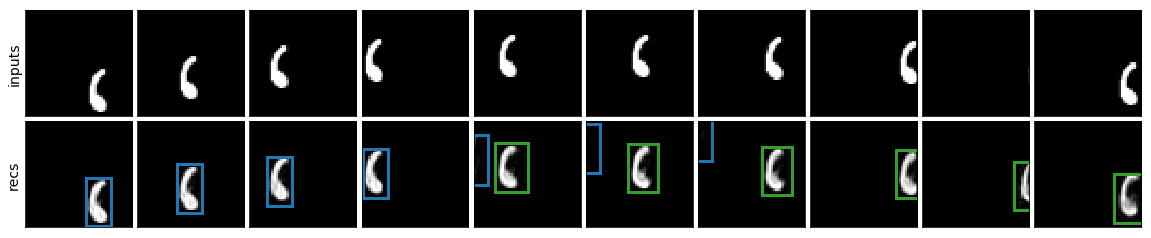

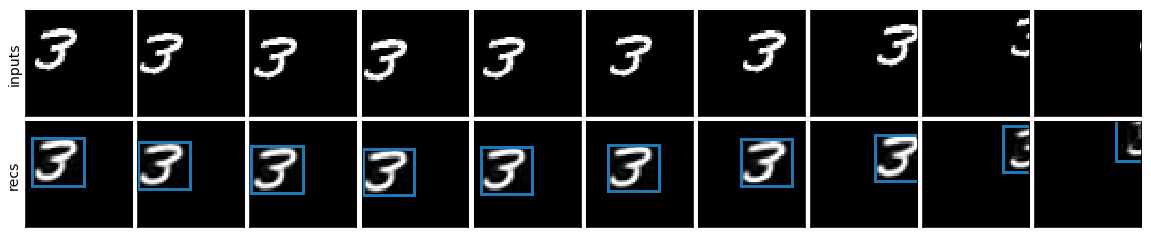

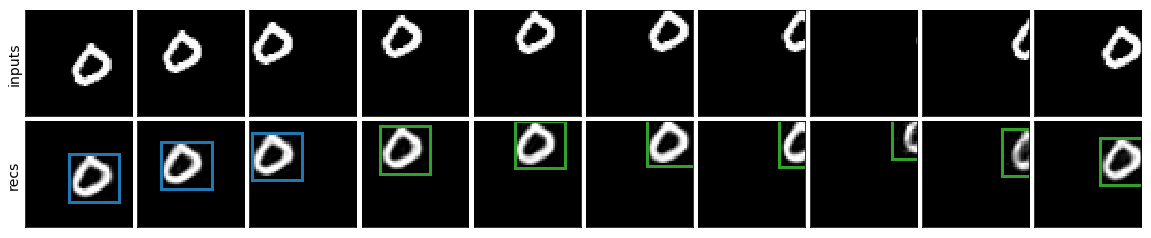

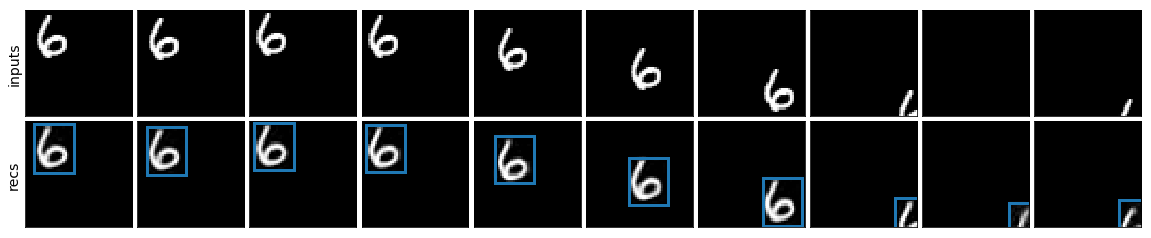

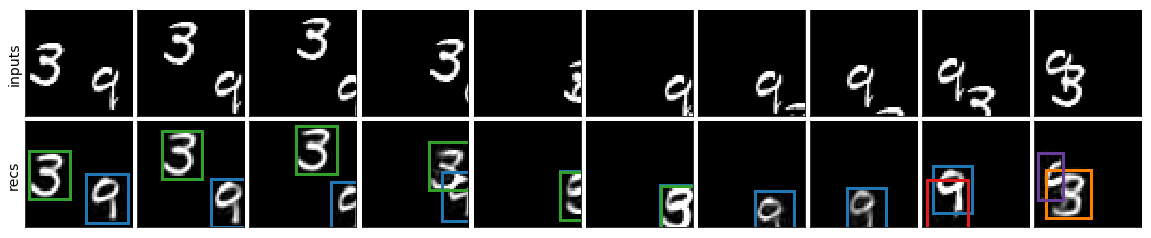

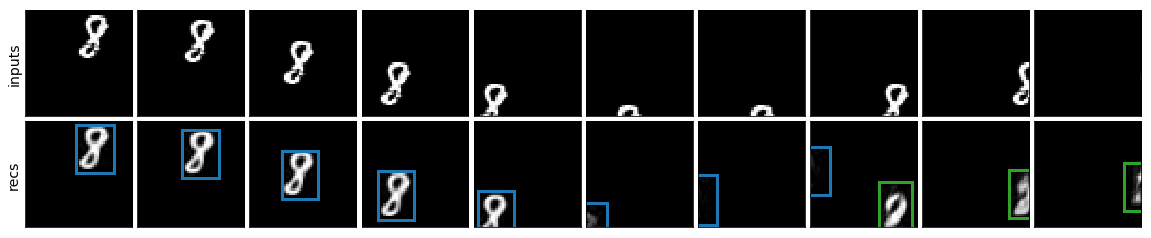

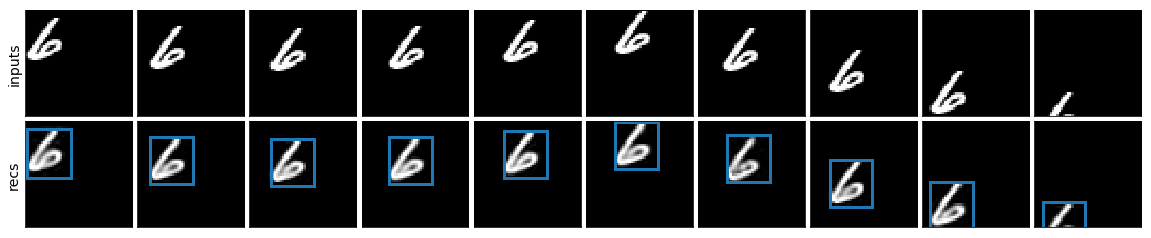

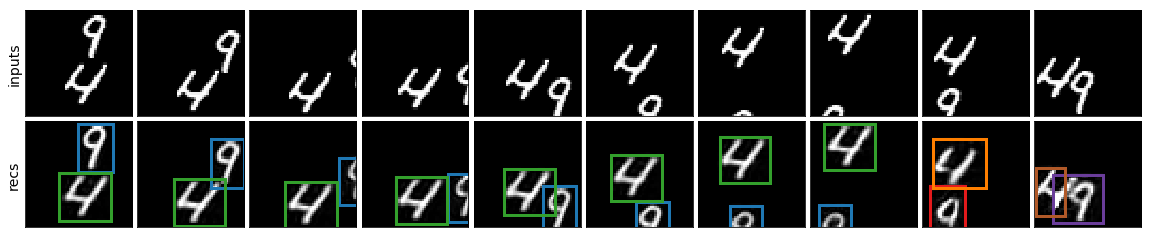

In [16]:
# evaluate with images from the validation set as input
imgs = sess.run(data_dict.valid_img)
tensor_values = sess.run(tensors, {data_dict.train_img: imgs})
tensor_values = [imgs] + tensor_values

# Plot! 
examples_to_display = 8
for b in xrange(F.batch_size):
    if examples_to_display == 0:
        break
        
    tensors_to_display = [tv[:, b] for tv in tensor_values]
    presence = tensors_to_display[-2]
    
    # skip inputs that contain no objects and are just black
    # comment the following `if` statement if you'd like to see
    # reconstructions of empty inputs
    if presence.sum() == 0:
        continue
        
    display_seq(*tensors_to_display)
    examples_to_display -= 1